In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [27]:
df=pd.read_csv('/Users/leahnewmark/Desktop/Leah/ML-Capstone/Real Breast Cancer Data.csv')

In [28]:
print(df.head())

     Patient_ID  Age  Gender  Protein1  Protein2  Protein3  Protein4  \
0  TCGA-D8-A1XD   36  FEMALE  0.080353   0.42638   0.54715  0.273680   
1  TCGA-EW-A1OX   43  FEMALE -0.420320   0.57807   0.61447 -0.031505   
2  TCGA-A8-A079   69  FEMALE  0.213980   1.31140  -0.32747 -0.234260   
3  TCGA-D8-A1XR   56  FEMALE  0.345090  -0.21147  -0.19304  0.124270   
4  TCGA-BH-A0BF   56  FEMALE  0.221550   1.90680   0.52045 -0.311990   

  Tumour_Stage                      Histology ER status PR status HER2 status  \
0          III  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   
1           II             Mucinous Carcinoma  Positive  Positive    Negative   
2          III  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   
3           II  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   
4           II  Infiltrating Ductal Carcinoma  Positive  Positive    Negative   

                  Surgery_type Date_of_Surgery Date_of_Last_Visit  \
0  Modified

In [29]:
# Check for missing values
print("Missing values before dropna:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)


Missing values before dropna:
Patient_ID             0
Age                    0
Gender                 0
Protein1               0
Protein2               0
Protein3               0
Protein4               0
Tumour_Stage           0
Histology              0
ER status              0
PR status              0
HER2 status            0
Surgery_type           0
Date_of_Surgery        0
Date_of_Last_Visit    17
Patient_Status        13
dtype: int64


In [30]:
def check_df(dataframe):
    print(" SHAPE ".center(70,'~'))
    print(dataframe.shape)
    print(" TYPES ".center(70,'~'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'~'))
    print(dataframe.head())
    print(" DESCRIBE ".center(70,'~'))
    print(dataframe.describe().T)
check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(317, 16)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Patient_ID             object
Age                     int64
Gender                 object
Protein1              float64
Protein2              float64
Protein3              float64
Protein4              float64
Tumour_Stage           object
Histology              object
ER status              object
PR status              object
HER2 status            object
Surgery_type           object
Date_of_Surgery        object
Date_of_Last_Visit     object
Patient_Status         object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
     Patient_ID  Age  Gender  Protein1  Protein2  Protein3  Protein4  \
0  TCGA-D8-A1XD   36  FEMALE  0.080353   0.42638   0.54715  0.273680   
1  TCGA-EW-A1OX   43  FEMALE -0.420320   0.57807   0.61447 -0.031505   
2  TCGA-A8-A079   69  FEMALE  0.213980   1.31140  -0.32747 -0.23426

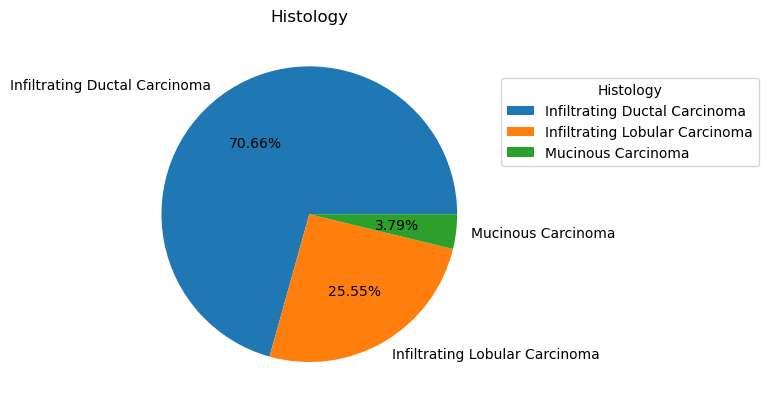

In [31]:
#histology pie chart
df['Histology'].value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.title('Histology')
plt.ylabel('') #remove y label
plt.legend(title="Histology", loc="center left", bbox_to_anchor=(1,0.75))
plt.show()

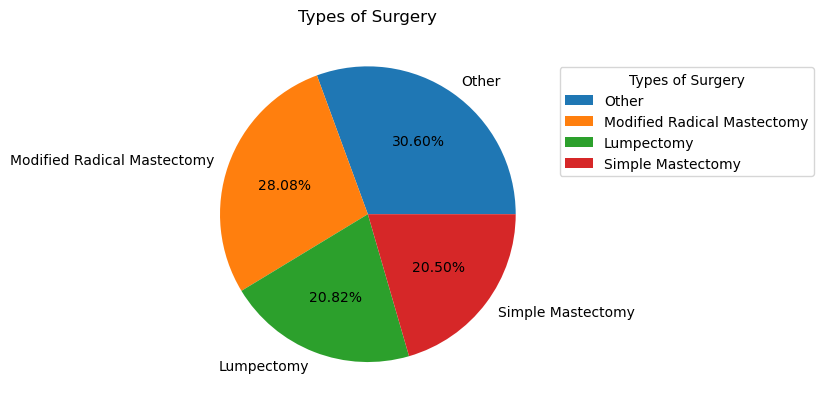

In [32]:
#Type of surgery pie chart
surgery= df['Surgery_type'].value_counts()
transactions= surgery.index
quantity= surgery.values
surgery.plot(kind='pie', autopct='%1.2f%%', title= "Types of Surgery")
plt.ylabel('')
plt.legend(title="Types of Surgery", loc="center left", bbox_to_anchor=(1,0.75))
plt.show()

In [33]:
df['Gender'].value_counts()
#Likely no need to include male pts in features, not enough sample

Gender
FEMALE    313
MALE        4
Name: count, dtype: int64

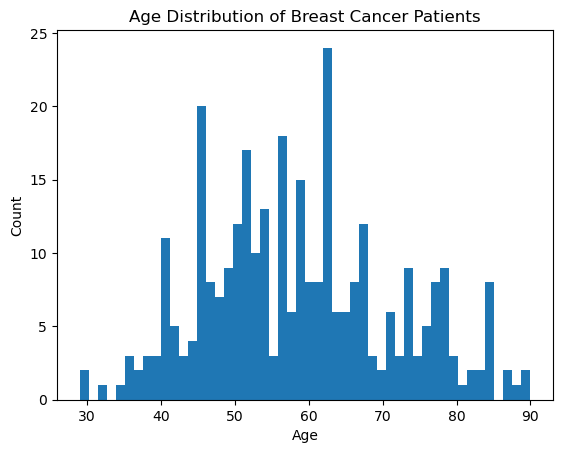

In [34]:
df['Age'].hist(bins = 50, grid = False)
plt.xlabel(xlabel = "Age")
plt.ylabel(ylabel = "Count")
plt.title("Age Distribution of Breast Cancer Patients")
plt.show()

In [35]:
# This was a good idea I picked up from alt code to create multiple pie charts or other future graphs.

def plot_pie_chart(column, title):
    # define Seaborn color palette to use
    palette_color = sns.color_palette('bright')

    # plotting data on chart
    plt.pie(df[column].value_counts(), labels=df[column].unique(), colors=palette_color, autopct='%.0f%%')

    plt.title(title)
    # displaying chart
    plt.show()

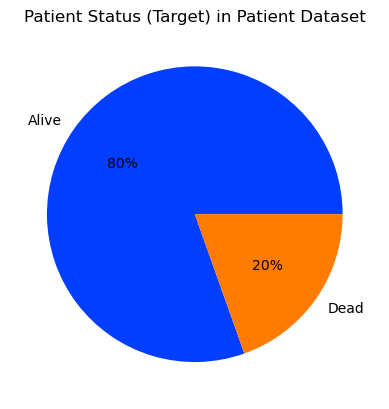

In [36]:
plot_pie_chart("Patient_Status", "Patient Status (Target) in Patient Dataset")
#my code shows 80% living pt, sample code had 79%.

The target (living, dead) is fairly unbalanced towards patients that are alive. This would make it difficult to properly make classifications without resampling the dataset.

Preprocess

In [37]:
#make a copy of df and drop uninformative features
df_info= df.copy().drop(columns=['Patient_ID', 'Gender', 'ER status', 'PR status'])
le= LabelEncoder()
#create target variable column
df_info['Patient_Status_le']= le.fit_transform(df_info['Patient_Status'])
df_info['HER2_Status_le'] = le.fit_transform(df_info['HER2 status'])

#Ordinal encode data to keep order of categories
oe = OrdinalEncoder(dtype=int)
df_info['Tumour_Stage_oe'] = oe.fit_transform(np.array(df_info['Tumour_Stage']).reshape(-1, 1))

df_info.drop(columns=['Tumour_Stage', 'Date_of_Surgery', 'Date_of_Last_Visit'], inplace=True)


In [38]:
df_info= pd.get_dummies(df_info, columns=['Histology'], dtype = int)

sample the data due to imbalance of dead vs living


In [39]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier


# Define features and target
target = df_info['Patient_Status_le']
features= df_info.drop(columns=['Patient_Status', 'Patient_Status_le', 'HER2 status', 'Surgery_type'])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.15, random_state = 42, stratify=df_info['Patient_Status_le'])

# # ## Resample dataset so that target feature is evenly distributed using regular SMOTE, not increasing overall samples of living and non living
# smote = SMOTE(k_neighbors=5, random_state=42)

# X_train, y_train = smote.fit_resample(X_train, y_train)


# # Count samples before SMOTE
print("Before SMOTE:")
print(f"Total samples: {X_train.shape[0]}")
print(f"Class distribution: {Counter(y_train)}")
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(sampling_strategy={0: 650, 1: 600},random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Convert back to DataFrame and Series if the original data was in those formats
X_train= pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train = pd.Series(y_train_resampled, name=y_train.name)

# Count samples after SMOTE
print("\nAfter SMOTE:")
print(f"Total samples: {X_train_resampled.shape[0]}")
print(f"Class distribution: {Counter(y_train_resampled)}")

Before SMOTE:
Total samples: 269
Class distribution: Counter({0: 216, 1: 53})

After SMOTE:
Total samples: 1093
Class distribution: Counter({1: 551, 0: 542})


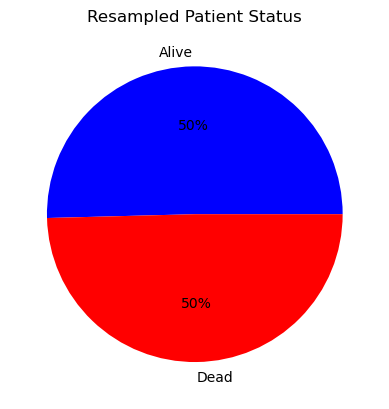

In [40]:
plt.pie(y_train.value_counts(), labels=df_info['Patient_Status'].unique(), colors='bright', autopct='%.0f%%')

plt.title("Resampled Patient Status")
# displaying chart
plt.show()

Smapling with replacement- which was not as helpful as SMOTE or SMOTE ENN

In [41]:
# from imblearn.over_sampling import SMOTE
# from sklearn.preprocessing import StandardScaler
# from sklearn.utils import resample

# # Set the desired augmentation factor (e.g., 1.5 times the original size)
# augmentation_factor = 3

# # Determine the number of samples to generate
# n_samples_to_generate = int(len(X_train) * (augmentation_factor - 1))

# # Perform random sampling with replacement on the entire training dataset
# X_train_augmented, y_train_augmented = resample(X_train, y_train,
#                                                 replace=True,  # Sample with replacement
#                                                 n_samples=n_samples_to_generate,  # Number of new samples
#                                                 random_state=42)

# # Combine the augmented data with the original data
# X_train_final = pd.concat([X_train, X_train_augmented], axis=0)
# y_train_final = pd.concat([y_train, y_train_augmented], axis=0)

# # Shuffle the final augmented dataset
# X_train_final, y_train_final = resample(X_train_final, y_train_final, random_state=42)

# # Print the shapes to verify the augmentation
# print("Original X_train shape:", X_train.shape)
# print("Augmented X_train shape:", X_train_final.shape)
# print("Original y_train shape:", y_train.shape)
# print("Augmented y_train shape:", y_train_final.shape)

# # Convert augmented data back to the original variables
# X_train = X_train_final
# y_train = y_train_final

Apply Normalized scaler and Standard Scaler

In [42]:
# Add min_max scaler
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler()
# Fit the scaler using Normalized scaler
X_train_norm = norm.fit_transform(X_train)
# Transform the test data using the same scaler
X_test_norm= norm.transform(X_test)

# Convert scaled arrays to DataFrames
X_train_norm_df = pd.DataFrame(X_train_norm, columns=features.columns)
X_test_norm_df = pd.DataFrame(X_test_norm, columns=features.columns)


# Fit the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features.columns)


In [43]:
# Checking the shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_train_norm_df shape:", X_train_norm_df.shape)
print("X_train_scaled_df shape:", X_train_scaled_df.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1093, 10)
X_train_norm_df shape: (1093, 10)
X_train_scaled_df shape: (1093, 10)
y_train shape: (1093,)
X_test shape: (48, 10)
y_test shape: (48,)


Support Vector Classification Model
Best estimator chosen during the fitting/GridSearch shows hyperparameters for the model

In [44]:
#was taking too long to run and was not best model in all prior test cases so commented it out.

# from sklearn.svm import SVC
# svc = SVC(probability=True)
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}
# clf = GridSearchCV(estimator=svc, param_grid=parameters, n_jobs=50)

# #not scaled
# clf.fit(X_train, y_train)
# clf.best_estimator_

# #normslized
# clf.fit(X_train_norm_df, y_train)
# clf.best_estimator_

# #standard scaler
# svc = SVC(probability=True)
# parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
# clf = GridSearchCV(svc, parameters, n_jobs=-1)
# clf.fit(X_train_scaled_df, y_train)
# clf.fit(X_train_scaled, y_train)

# clf.best_estimator_


Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define parameter grid with valid parameters for LogisticRegression
param_grid = [
    {
        'max_iter': [5000, 10000, 20000],
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0, 0.5, 1]
    },
    {
        'max_iter': [5000, 10000, 20000],
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs']  # l1_ratio is not used for l2 penalty
    }
]

# Initialize the Logistic Regression model
logit = LogisticRegression(random_state=42)

# Initialize GridSearchCV for elasticnet with scaled data
grid_search_elasticnet_scaled = GridSearchCV(logit, param_grid, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
try:
    grid_search_elasticnet_scaled.fit(X_train_scaled_df, y_train)
    print("ElasticNet (Scaled Data):")
    print(f"Best Parameters: {grid_search_elasticnet_scaled.best_params_}")
    print(f"Best F1 Score: {grid_search_elasticnet_scaled.best_score_}")
except Exception as e:
    print(f"Error during ElasticNet (Scaled Data) GridSearchCV: {e}")

# Initialize GridSearchCV for elasticnet with normalized data
grid_search_elasticnet_normal = GridSearchCV(logit, param_grid, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
try:
    grid_search_elasticnet_normal.fit(X_train_norm_df, y_train)
    print("ElasticNet (Normalized Data):")
    print(f"Best Parameters: {grid_search_elasticnet_normal.best_params_}")
    print(f"Best F1 Score: {grid_search_elasticnet_normal.best_score_}")
except Exception as e:
    print(f"Error during ElasticNet (Normalized Data) GridSearchCV: {e}")


ElasticNet (Scaled Data):
Best Parameters: {'C': 0.01, 'l1_ratio': 1, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best F1 Score: 0.6703153411197003
ElasticNet (Normalized Data):
Best Parameters: {'C': 0.01, 'l1_ratio': 0.5, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best F1 Score: 0.6703153411197003


Logistic regression with updated parameters from 3500 to 5000 and l1_ratio= 0.5, l1_ratio has lesser impact on the F1 score  compared to increasing max_iter. Normalized data works best in logistic regression but still low F1 score


Cross-Validation F1 Scores: [0.61538462 0.5625     0.64573991 0.58215962 0.67811159]
Mean F1 Score: 0.616779147618899

Cross-Validation F1 Scores: [0.62032086 0.55454545 0.63348416 0.57276995 0.66375546]
Mean F1 Score: 0.6089751769246565

Cross-Validation F1 Scores: [0.6        0.5520362  0.64253394 0.58215962 0.67521368]
Mean F1 Score: 0.6103886870746853

Model: Unscaled
Accuracy: 0.8125
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        39
           1       0.00      0.00      0.00         9

    accuracy                           0.81        48
   macro avg       0.41      0.50      0.45        48
weighted avg       0.66      0.81      0.73        48

Confusion Matrix:
 [[39  0]
 [ 9  0]]

Model: Normalized
Accuracy: 0.8125
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89        39
           1       0.50      0.11      0.18      

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


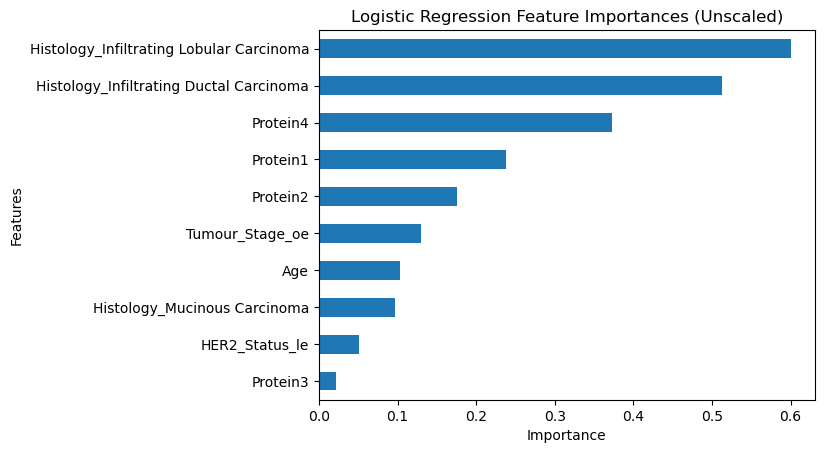

In [46]:
def log_reg(X, y, params):
    logit = LogisticRegression(**params)

    # Perform cross-validation
    cv_scores = cross_val_score(logit, X, y, cv=5, scoring='f1')
    print("\nCross-Validation F1 Scores:", cv_scores)
    print("Mean F1 Score:", cv_scores.mean())

    logit.fit(X, y)
    # Fit the model
    return logit

def log_evaluate(model, X_t, y_t, model_name):


    # Predict on the test set
    y_pred = model.predict(X_t)

    # Evaluate the model
    accuracy = accuracy_score(y_t, y_pred)
    report = classification_report(y_t, y_pred)
    conf_matrix = confusion_matrix(y_t, y_pred)

    print("\nModel:", model_name)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)

    return model

params = {
    'max_iter': 5000,
    'penalty': 'elasticnet',
    'solver': 'saga',
    'l1_ratio': 1,
    'random_state': 42
}


logit = LogisticRegression(max_iter=5000, penalty= 'elasticnet', solver= 'saga', l1_ratio= 1, random_state=42)

# Initialize and perform cross-validation
logit_unscaled = log_reg(X_train, y_train, params)
logit_unscaled = logit.fit(X_train, y_train)

logit_norm = log_reg(X_train_norm_df, y_train, params)
logit_norm = logit.fit(X_train_norm_df, y_train)

logit_scaled = log_reg(X_train_scaled_df, y_train, params)
logit_scaled = logit.fit(X_train_scaled_df, y_train)

# evaluate models
log_evaluate(logit_unscaled, X_test, y_test, "Unscaled")
log_evaluate(logit_norm, X_test_norm_df, y_test, "Normalized")
log_evaluate(logit_scaled, X_test_scaled_df, y_test, "Standard Scaled")

# Feature importances for the unscaled model
logit_importances = logit_unscaled.coef_[0]
logit_feature_importances = pd.Series(index=X_train.columns, data=np.abs(logit_importances))
logit_feature_importances = logit_feature_importances.sort_values(ascending=True)
logit_feature_importances.plot(kind='barh', title='Logistic Regression Feature Importances (Unscaled)', xlabel='Importance', ylabel='Features')
plt.show()

Per origincal author: Following training of the Logisitic Regression model on the dataset, the most important features that contribute to classification of Patient Status include Histology of ILC, IDC carcinomas and patient is HER2+/-. Features that don't seem to contribute to the model's prediction include age, stage of tumour. Suprisingly, the stage of a tumour does not seem to contribute much informationally to the model, despite domain knowledge of this feature. This may be due to skewness of the data towards stage III cancer as this is prevalent in ~60% of the patients in the dataset. HER2 status also is a informative input feature for the model as we understand by HER2++ typically as a predictor of cancer cases.

Random Forest Classifier


Cross-Validation F1 Scores: [0.90740741 0.90666667 0.88702929 0.90517241 0.93043478]
Mean F1 Score: 0.9073421118357604

Cross-Validation F1 Scores: [0.90740741 0.90666667 0.88702929 0.90128755 0.93043478]
Mean F1 Score: 0.9065651398067534

Cross-Validation F1 Scores: [0.90740741 0.90666667 0.88702929 0.90517241 0.93043478]
Mean F1 Score: 0.9073421118357604

Cross-Validation F1 Scores: [0.90740741 0.90666667 0.88702929 0.90517241 0.93043478]
Mean F1 Score: 0.9073421118357604

Cross-Validation F1 Scores: [0.90740741 0.90666667 0.88702929 0.90128755 0.93043478]
Mean F1 Score: 0.9065651398067534

Cross-Validation F1 Scores: [0.90740741 0.90666667 0.88702929 0.90517241 0.93043478]
Mean F1 Score: 0.9073421118357604

Model: Unscaled
Accuracy: 0.8125
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        39
           1       0.00      0.00      0.00         9

    accuracy                           0.81        48
   m

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


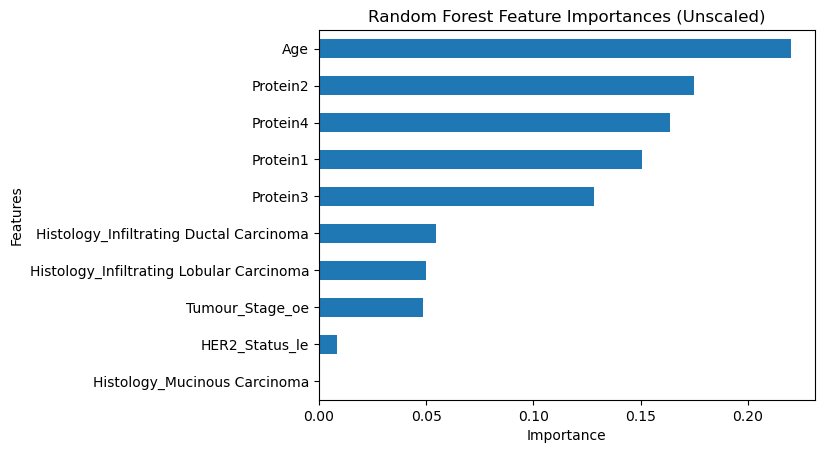


Best Model Scaled RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=3,
                       random_state=42)
Cross-Validation F1 Scores: [0.94339623 0.95412844 0.97777778 0.95964126 0.96396396]
Mean F1 Score: 0.9597815328258379


In [47]:
def randforestClass(X, y, params):
    forest = RandomForestClassifier(**params)

    # Perform cross-validation
    cv_scores = cross_val_score(forest, X, y, cv=5, scoring='f1')
    print("\nCross-Validation F1 Scores:", cv_scores)
    print("Mean F1 Score:", cv_scores.mean())

    # Fit the model
    forest_fitted= forest.fit(X, y)
    return forest

def forest_evaluate(model, X_t, y_t, model_name):



    # Predict on the test set
    y_pred = model.predict(X_t)

    # Evaluate the model
    accuracy = accuracy_score(y_t, y_pred)
    report = classification_report(y_t, y_pred)
    conf_matrix = confusion_matrix(y_t, y_pred)

    print("\nModel:", model_name)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)

    return model

params = {
    'n_estimators': 500,
    'max_depth': 8,
    'max_features': 3,
    'oob_score': True,
    'random_state': 42
}

forest=RandomForestClassifier(n_estimators=500, max_depth=8, max_features=3, oob_score= True, random_state=42)

# Initialize and perform cross-validation
forest_unscaled = randforestClass(X_train, y_train, params)
forest_unscaled = forest.fit(X_train, y_train)

forest_norm = randforestClass(X_train_norm_df, y_train, params)
forest_norm = forest.fit(X_train_norm_df, y_train)

forest_scaled = randforestClass(X_train_scaled_df, y_train, params)
forest_scaled = forest.fit(X_train_scaled_df, y_train)

forest= randforestClass(X_train, y_train, params)
forest_norm = randforestClass(X_train_norm_df, y_train, params)
forest_scaled = randforestClass(X_train_scaled_df, y_train, params)

# evaluate models
forest_evaluate(forest_unscaled, X_test, y_test, "Unscaled")
forest_evaluate(forest_norm, X_test_norm_df, y_test, "Normalized")
forest_evaluate(forest_scaled, X_test_scaled_df, y_test, "Standard Scaled")

# Feature importances for the unscaled model
forest_importances = pd.Series(index=X_train.columns, data=forest_unscaled.feature_importances_)
forest_importances = forest_importances.sort_values(ascending=True)
forest_importances.plot(kind='barh', title='Random Forest Feature Importances (Unscaled)', xlabel='Importance', ylabel='Features')
plt.show()


# # Create a DataFrame for feature importances
# forest_feature_importance = pd.DataFrame(
#     index=original_column_names,  # Ensure these match the features used for fitting
#     data=forest.feature_importances_,
#     columns=['Feature_Importance']
# )

#check best parameters
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3,5,8],
    'max_features':[1,2,3],
    'class_weight': ['balanced', None]  # Use balanced to handle class imbalance
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model_scaled = grid_search.best_estimator_
print("\nBest Model Scaled", best_model_scaled)


# Cross-validation for RandomForest
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42), X_train, y_train, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean()}")

My output is in line with original authors output, showing age and protein and most important features for survival prediction.

Decison Tree Classifier


Cross-Validation F1 Scores: [0.73636364 0.76984127 0.74131274 0.79051383 0.68627451]
Mean F1 Score: 0.7448611982627327

Cross-Validation F1 Scores: [0.73636364 0.76984127 0.74615385 0.79051383 0.68627451]
Mean F1 Score: 0.7458294192309538

Cross-Validation F1 Scores: [0.73636364 0.76984127 0.74615385 0.79051383 0.68627451]
Mean F1 Score: 0.7458294192309538

Model: Unscaled
Accuracy: 0.6458333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.67      0.75        39
           1       0.28      0.56      0.37         9

    accuracy                           0.65        48
   macro avg       0.57      0.61      0.56        48
weighted avg       0.76      0.65      0.68        48

Confusion Matrix:
 [[26 13]
 [ 4  5]]

Model: Normalized
Accuracy: 0.375
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.31      0.44        39
           1       0.18      0.67    

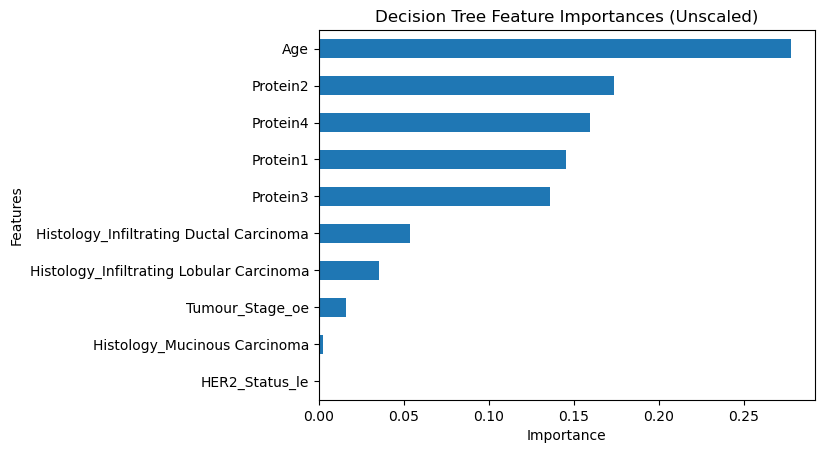

In [48]:
from sklearn.tree import DecisionTreeClassifier

def d_tree_class(X, y, params):
    tree_gini = DecisionTreeClassifier(**params)

    # Perform cross-validation
    cv_scores = cross_val_score(tree_gini, X, y, cv=5, scoring='f1')
    print("\nCross-Validation F1 Scores:", cv_scores)
    print("Mean F1 Score:", cv_scores.mean())

    tree_gini_fitted= tree_gini.fit(X_train, y_train)
    return tree_gini

def tree_evaluate(model, X_t, y_t, model_name):
    # Fit the model


    # Predict on the test set
    y_pred = model.predict(X_t)

    # Evaluate the model
    accuracy = accuracy_score(y_t, y_pred)
    report = classification_report(y_t, y_pred)
    conf_matrix = confusion_matrix(y_t, y_pred)

    print("\nModel:", model_name)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)

    return model

params = {
    'criterion': 'gini',
    'max_depth': 8,
    'max_features': 3,
    'random_state': 42
}

tree_gini = DecisionTreeClassifier(criterion= 'gini', max_depth=8, max_features= 3, random_state= 42)

# Initialize and perform cross-validation
tree_gini_unscaled = d_tree_class(X_train, y_train, params)
tree_gini_unscaled= tree_gini.fit(X_train, y_train)

tree_gini_norm = d_tree_class(X_train_norm_df, y_train, params)
tree_gini_norm = tree_gini.fit(X_train_norm_df, y_train)

tree_gini_scaled = d_tree_class(X_train_scaled_df, y_train, params)
tree_gini_scaled = tree_gini.fit(X_train_scaled_df, y_train)

#evaluate models
tree_unscaled_eval= tree_evaluate(tree_gini_unscaled, X_test, y_test, "Unscaled")
tree_norm_eval= tree_evaluate(tree_gini_norm, X_test_norm_df, y_test, "Normalized")
tree_scaled_eval= tree_evaluate(tree_gini_scaled, X_test_scaled_df, y_test, "Standard Scaled")

# Feature importances for the unscaled model
tree_gini_importances = pd.Series(index=X_train.columns, data=tree_gini_unscaled.feature_importances_)
tree_gini_importances = tree_gini_importances.sort_values(ascending=True)
tree_gini_importances.plot(kind='barh', title='Decision Tree Feature Importances (Unscaled)', xlabel='Importance', ylabel='Features')
plt.show()



Interestingly, the lowest scored features for importance are presence of specific carcinoma's (ILC, IDC, MC), HER2 status in this code. The Feature importances between trees and random forest are reversed compared to linear regression. 

In [49]:

def plot_ROC(model, title, X, Y):
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    roc_auc = roc_auc_score(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


Future analysis using ROC curves on models- would like to discuss these curves

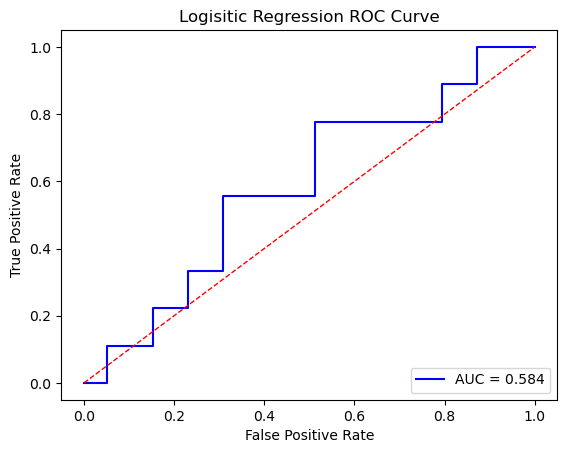

Accuracy Score: 0.8125
Confusion Matrix:
 [[39  0]
 [ 9  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        39
           1       0.00      0.00      0.00         9

    accuracy                           0.81        48
   macro avg       0.41      0.50      0.45        48
weighted avg       0.66      0.81      0.73        48



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


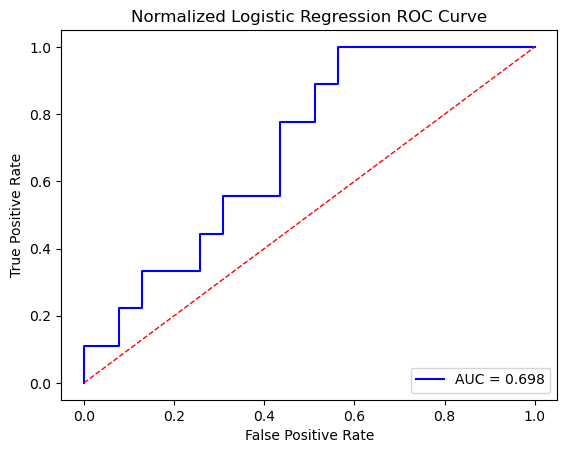

Accuracy Score: 0.8125
Confusion Matrix:
 [[38  1]
 [ 8  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89        39
           1       0.50      0.11      0.18         9

    accuracy                           0.81        48
   macro avg       0.66      0.54      0.54        48
weighted avg       0.76      0.81      0.76        48



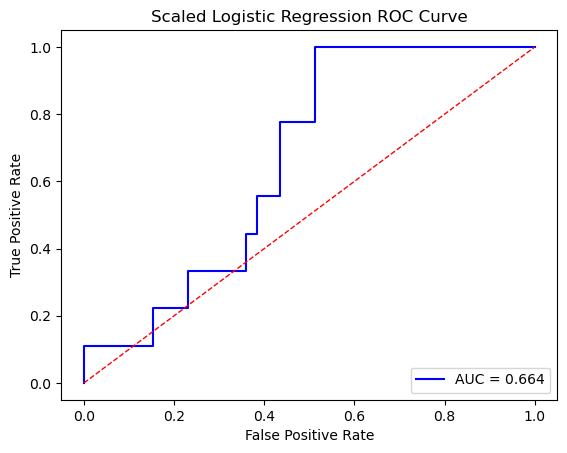

Accuracy Score: 0.6458333333333334
Confusion Matrix:
 [[28 11]
 [ 6  3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77        39
           1       0.21      0.33      0.26         9

    accuracy                           0.65        48
   macro avg       0.52      0.53      0.51        48
weighted avg       0.71      0.65      0.67        48



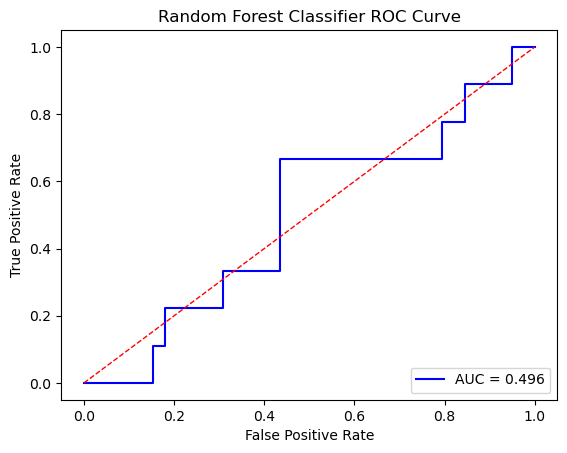

Accuracy Score: 0.7291666666666666
Confusion Matrix:
 [[31  8]
 [ 5  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.83        39
           1       0.33      0.44      0.38         9

    accuracy                           0.73        48
   macro avg       0.60      0.62      0.60        48
weighted avg       0.76      0.73      0.74        48



/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


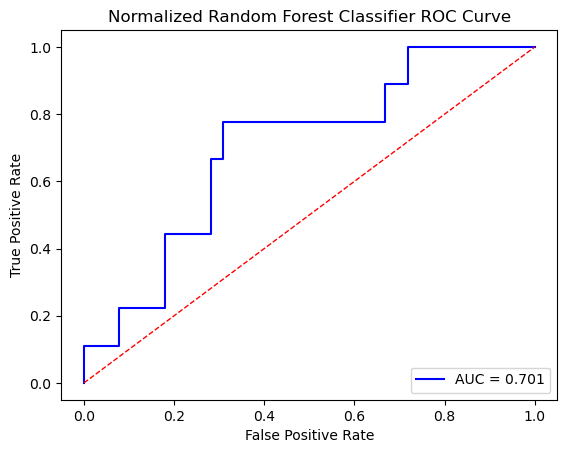

Accuracy Score: 0.7708333333333334
Confusion Matrix:
 [[35  4]
 [ 7  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86        39
           1       0.33      0.22      0.27         9

    accuracy                           0.77        48
   macro avg       0.58      0.56      0.57        48
weighted avg       0.74      0.77      0.75        48



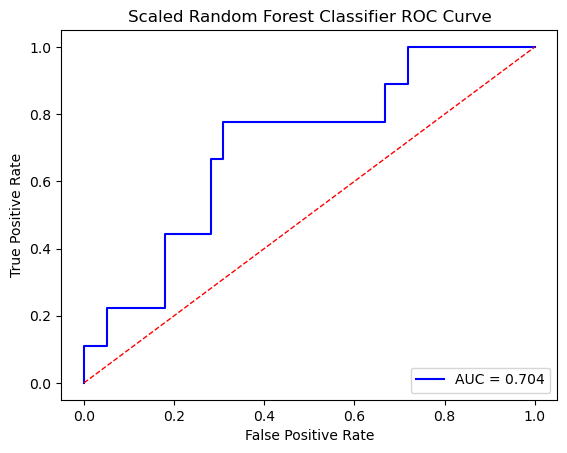

Accuracy Score: 0.7083333333333334
Confusion Matrix:
 [[31  8]
 [ 6  3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.82        39
           1       0.27      0.33      0.30         9

    accuracy                           0.71        48
   macro avg       0.56      0.56      0.56        48
weighted avg       0.73      0.71      0.72        48



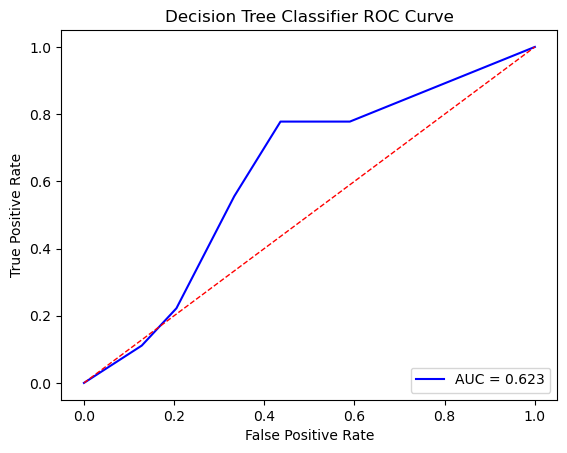

Accuracy Score: 0.6458333333333334
Confusion Matrix:
 [[26 13]
 [ 4  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.67      0.75        39
           1       0.28      0.56      0.37         9

    accuracy                           0.65        48
   macro avg       0.57      0.61      0.56        48
weighted avg       0.76      0.65      0.68        48



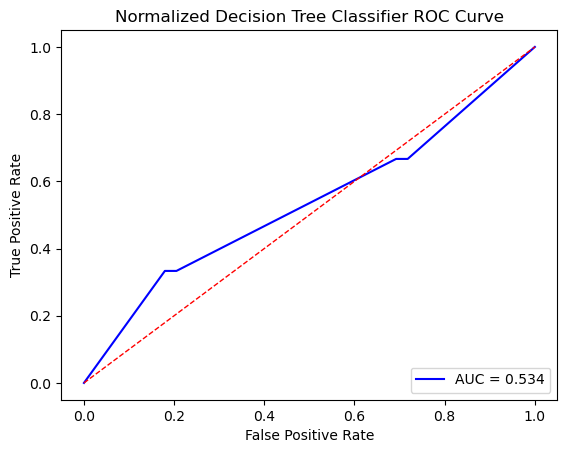

Accuracy Score: 0.375
Confusion Matrix:
 [[12 27]
 [ 3  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.31      0.44        39
           1       0.18      0.67      0.29         9

    accuracy                           0.38        48
   macro avg       0.49      0.49      0.37        48
weighted avg       0.68      0.38      0.41        48



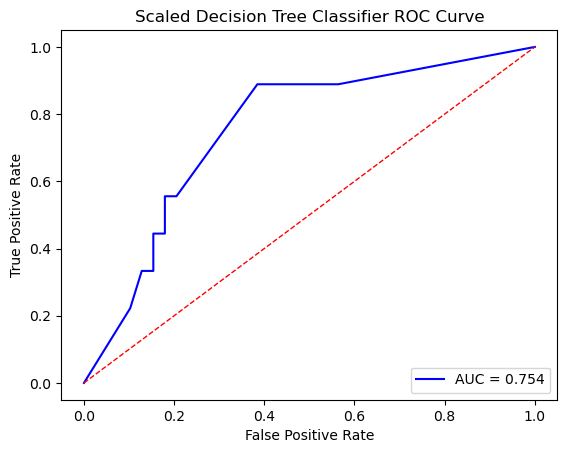

Accuracy Score: 0.6458333333333334
Confusion Matrix:
 [[23 16]
 [ 1  8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.59      0.73        39
           1       0.33      0.89      0.48         9

    accuracy                           0.65        48
   macro avg       0.65      0.74      0.61        48
weighted avg       0.84      0.65      0.68        48



In [50]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report
# Performance on test data

# Performance on testing data with Logistic Regression
plot_ROC(logit_unscaled, "Logisitic Regression ROC Curve", X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=logit.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=logit.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=logit.predict(X_test))}")

plot_ROC(logit_norm, "Normalized Logistic Regression ROC Curve", X_test_norm_df, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=logit.predict(X_test_norm_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=logit.predict(X_test_norm_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=logit.predict(X_test_norm_df))}")

plot_ROC(logit_scaled, "Scaled Logistic Regression ROC Curve", X_test_scaled_df, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=logit.predict(X_test_scaled_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=logit.predict(X_test_scaled_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=logit.predict(X_test_scaled_df))}")

# Random Forest

plot_ROC(forest_unscaled, "Random Forest Classifier ROC Curve",  X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=forest.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=forest.predict(X_test))}")

plot_ROC(forest_norm, "Normalized Random Forest Classifier ROC Curve", X_test_norm, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=forest.predict(X_test_norm_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test_norm_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=forest.predict(X_test_norm_df))}")

plot_ROC(forest_scaled, "Scaled Random Forest Classifier ROC Curve", X_test_scaled_df, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=forest.predict(X_test_scaled_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test_scaled_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=forest.predict(X_test_scaled_df))}")

# Decision Tree
plot_ROC(tree_gini_unscaled, "Decision Tree Classifier ROC Curve",  X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=tree_gini.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=tree_gini.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=tree_gini.predict(X_test))}")

# Performance on testing data with Decision Tree
plot_ROC(tree_gini_norm, "Normalized Decision Tree Classifier ROC Curve", X_test_norm_df, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=tree_gini.predict(X_test_norm_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=tree_gini.predict(X_test_norm_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=tree_gini.predict(X_test_norm_df))}")

# Decision Tree scaled
plot_ROC(tree_gini_scaled, "Scaled Decision Tree Classifier ROC Curve", X_test_scaled_df, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=tree_gini.predict(X_test_scaled_df))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=tree_gini.predict(X_test_scaled_df))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=tree_gini.predict(X_test_scaled_df))}")



Curves showing stair set could indicate that we are overfitting on small amount of data and need more samples.

Logistic regression classification report: Precision- out of all the features that the model predicted were coorelated with cancer only 31% of them were actually coorelated, recall- out of all the features that actually were associated with cancer the model predicted this outcome correctly 44% of the time, f1-score was 36. This model does a poor job.
It still is above the ROC curve.

Support vector  machine was worse followed by random forest and then decision tree.

This is suggestive of overfitting. Our test set is 15% of the data. Data Augmentation may be required.

Conclusion:

Standard scaler improves accurance on test set for random forest and this is the only model that shows improvements in accuracy once scaler is applied.

Normalized scaler improves accuracy only negligably, on logistic regression.

Normalizing decision tree puts more AUC and improves precision but accuracy is still low at 0.61

Augmenting the data did not improve performance of models.

Basic logistic regression without scaling seems to be best for this data.